# Transfer Learning Example with Google Colab.

This notebook contains a simple tutorial of the trasnfer learning.

## Reference

[Pytorch tutorial for transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Main Implementation

Before run this code, 
**Make sure that you have enabled the GPU under Edit -> Notebook Settings.**

In this example, we will use ResNet18 pretrained model to classify the small dataset. We will focus on classifying bees and ants. We will initialize the network with a pretrained network and change the last fully connected layer with two outputs. And we will train the network. 

First, let's download small dataset that only contains the data of bees and ants. To do this, we need to access your google drive to save the dataset. Click the link next "Go to this URL in a browser" and copy/paste the authorization code.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/')
os.getcwd()
if not os.path.exists('data'):
        os.makedirs('data')
os.chdir('data')

# download the small dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

os.chdir('..')

%matplotlib inline
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2020-08-06 05:35:36--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 143.204.191.91, 143.204.191.59, 143.204.191.26, ...
Connecting to download.pytorch.org (download.pytorch.org)|143.204.191.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.3’

hymenoptera_data.zi 100%[===================>]  45.10M  39.9MB/s    in 1.1s    

2020-08-06 05:35:37 (39.9 MB/s) - ‘hymenoptera_data.zip.3’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


Next, let's define the dataset in pytorch. We can normalize and set the type of the dataset by using below code: 

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Here is an example of the dataset. 

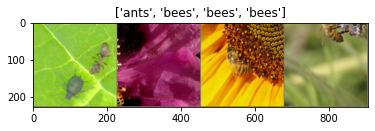

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

To help the training, the scheduler has been introduced. The scheduler, which comes from torch.optim.lr_scheduler, adjusts the learning rate based on the number of epochs. And we will save the best model based on the training accuracy. 

In [4]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # scheduler to adjust learning rate during training
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


### Visualizing a model 


In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Next, we will load a pretrained Resnet18 model from torchivision.models. We can even reset final layer of the pretrained Resnet. 

In [6]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Choose the number of epoch you want. 20~25 epoch will be enough to train well. 

In [7]:
model = train(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5626 Acc: 0.7500
val Loss: 0.3764 Acc: 0.8627

Epoch 1/9
----------
train Loss: 0.5061 Acc: 0.7951
val Loss: 0.3753 Acc: 0.8693

Epoch 2/9
----------
train Loss: 0.4277 Acc: 0.8361
val Loss: 0.3120 Acc: 0.8889

Epoch 3/9
----------
train Loss: 0.4880 Acc: 0.7992
val Loss: 0.2312 Acc: 0.9150

Epoch 4/9
----------
train Loss: 0.6311 Acc: 0.7746
val Loss: 0.3068 Acc: 0.8693

Epoch 5/9
----------
train Loss: 0.5529 Acc: 0.7869
val Loss: 0.4772 Acc: 0.8366

Epoch 6/9
----------
train Loss: 0.3534 Acc: 0.8115
val Loss: 0.2542 Acc: 0.9085

Epoch 7/9
----------
train Loss: 0.3628 Acc: 0.8525
val Loss: 0.2466 Acc: 0.9020

Epoch 8/9
----------
train Loss: 0.2941 Acc: 0.8811
val Loss: 0.2691 Acc: 0.8889

Epoch 9/9
----------
train Loss: 0.3319 Acc: 0.8607
val Loss: 0.2796 Acc: 0.8824

Training complete in 0m 59s
Best val Acc: 0.915033


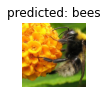

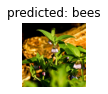

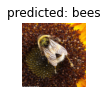

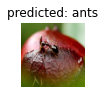

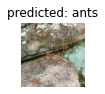

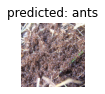

In [8]:
visualize_model(model)
